<a href="https://colab.research.google.com/github/bkrant/DS3-Predictive-Modeling-Challenge/blob/master/WaterPump_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from google.colab import files
uploaded = files.upload()

Saving sample_submission.csv to sample_submission.csv
Saving test_features.csv to test_features.csv
Saving train_features.csv to train_features.csv
Saving train_labels.csv to train_labels.csv


In [0]:
test_features = pd.read_csv('test_features.csv')
df_train_labels = pd.read_csv('train_labels.csv')
df_train_features = pd.read_csv('train_features.csv')
df = pd.merge(df_train_features, df_train_labels, how='inner', on='id')

In [38]:
df[df.amount_tsh.isnull()]['amount_tsh']

Series([], Name: amount_tsh, dtype: float64)

In [0]:
df.columns

In [0]:
df.groupby(['region','district_code'])[['amount_tsh']].transform('median')

In [0]:
df['amount_tsh'].replace(0.0, np.nan, inplace=True)

In [89]:
df[df['amount_tsh']==0]['amount_tsh']

Series([], Name: amount_tsh, dtype: float64)

In [0]:
df['amount_tsh'].fillna(df.groupby(['region', 'district_code'])['amount_tsh'].transform('median'))

In [0]:
df['amount_tsh'].replace(0.0, np.nan).fillna(df.groupby(['region', 'district_code'])['amount_tsh'].transform('median'))

In [176]:
def wrangle(X):  
  X = X.copy()  
  X = X.set_index('id')
  nans = ['gps_height', 'population', 'amount_tsh', 'construction_year']
  for col in nans:
    X[col].replace(0.0, np.nan, inplace=True)
  #X['gps_height'].replace(0.0, np.nan, inplace=True)
  #X['population'].replace(0.0, np.nan, inplace=True)
  #X['amount_tsh'].replace(0.0, np.nan, inplace=True)
  #X['construction_year'].replace(0.0, np.nan, inplace=True)
  X['amount_tsh'].fillna(X.groupby(['region'])['amount_tsh'].transform('median'), inplace=True)
  X['construction_year'].fillna(X.groupby(['region'])['construction_year'].transform('median'), inplace=True)
  X['date_recorded'] = pd.to_datetime(X['date_recorded'])
  X['years_service'] = X.date_recorded.dt.year - X.construction_year
  X = X.drop(columns=['quantity_group', 'waterpoint_type_group', 'source_type', 'payment_type', 'extraction_type_class', 
                      'extraction_type', 'longitude', 'latitude', 'date_recorded', 'construction_year', 'district_code'])
  return X

test_features = wrangle(test_features)
df = wrangle(df)
df_train_features.shape, df_train_labels.shape, df.shape

((59400, 40), (59400, 2), (59400, 30))

In [0]:
df['district_code'].value_counts()

In [104]:
df.isna().sum()

amount_tsh               12115
funder                    3635
gps_height               20438
installer                 3655
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
lga                          0
ward                         0
population               21381
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
extraction_type_group        0
management                   0
management_group             0
payment                      0
water_quality                0
quality_group                0
quantity                     0
source                       0
source_class                 0
waterpoint_type              0
status_group                 0
years_service            12115
dtype: int64

In [0]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['status_group'])
y = df['status_group']
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state=42, train_size=0.8)

In [6]:
all(df_train_features['source_type']==df_train_features['source']), all(test_features['source_type']==test_features['source'])

(False, False)

In [24]:
df_train_features['source_type'].value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [26]:
df_train_features['source'].value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [17]:
all(df_train_features['quantity_group']==df_train_features['quantity']), all(test_features['quantity_group']==test_features['quantity'])

(True, True)

In [19]:
all(df_train_features['waterpoint_type_group']==df_train_features['waterpoint_type']), all(test_features['waterpoint_type_group']==test_features['waterpoint_type'])

(False, False)

In [23]:
df_train_features[['source_type', 'source']].isnull().sum()

source_type    0
source         0
dtype: int64

In [20]:
df_train_features['waterpoint_type_group'].value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

In [21]:
df_train_features['waterpoint_type'].value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [27]:
df_train_features['payment_type'].value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

In [28]:
df_train_features['payment'].value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [29]:
df_train_features['management_group'].value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

In [30]:
df_train_features['management'].value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [31]:
df_train_features['extraction_type_class'].value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

In [32]:
df_train_features['extraction_type_group'].value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [33]:
df_train_features['extraction_type'].value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [34]:
df_train_features['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [0]:
df_train_features['scheme_name'].value_counts()

In [36]:
df_train_features['region'].value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [37]:
df_train_features['region_code'].value_counts()

11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64

In [77]:
df_train_features.head(2)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [8]:
df_train_labels.head(2)

,id,status_group
0,69572,functional
1,8776,functional


In [0]:
df.dtypes

In [178]:
df.isnull().sum()

amount_tsh               12115
funder                    3635
gps_height               20438
installer                 3655
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
lga                          0
ward                         0
population               21381
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
extraction_type_group        0
management                   0
management_group             0
payment                      0
water_quality                0
quality_group                0
quantity                     0
source                       0
source_class                 0
waterpoint_type              0
status_group                 0
years_service            12115
dtype: int64

In [36]:
df.describe(exclude='number')

,funder,installer,wpt_name,basin,subvillage,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type_group,management,management_group,payment,water_quality,quality_group,quantity,source,source_class,waterpoint_type,status_group
count,55765,55745,59400,59400,59029,59400,59400,56066,59400,55523,31234,56344,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,1897,2145,37400,9,19287,125,2092,2,1,12,2696,2,13,12,5,7,8,6,5,10,3,7,3
top,Government Of Tanzania,DWE,none,Lake Victoria,Madukani,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,vwc,user-group,never pay,soft,good,enough,spring,groundwater,communal standpipe,functional
freq,9084,17402,3563,10248,508,2503,307,51011,59400,36793,682,38852,26780,40507,52490,25348,50818,50818,33186,17021,45794,28522,32259


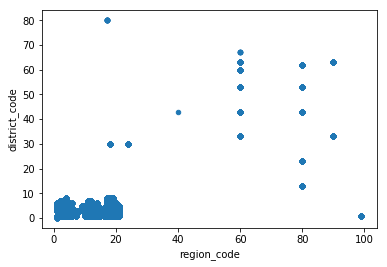

In [17]:
df.plot(x='region_code', y='district_code', kind='scatter');

In [22]:
df.status_group.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [23]:
y.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [24]:
y_train.value_counts(normalize=True)

functional                 0.544066
non functional             0.383186
functional needs repair    0.072748
Name: status_group, dtype: float64

In [25]:
y_val.value_counts(normalize=True)

functional                 0.540067
non functional             0.386700
functional needs repair    0.073232
Name: status_group, dtype: float64

In [26]:
y_test.value_counts(normalize=True)

functional                 0.538215
non functional             0.390236
functional needs repair    0.071549
Name: status_group, dtype: float64

In [178]:
pd.Series(y_pred).value_counts(normalize=True)

functional        0.699889
non functional    0.300111
dtype: float64

In [0]:
!pip install category_encoders

In [0]:
plt.figure(figsize=(10,3))

Validation accuracy: 0.6796296296296296 Train accuracy: 0.6784722222222223


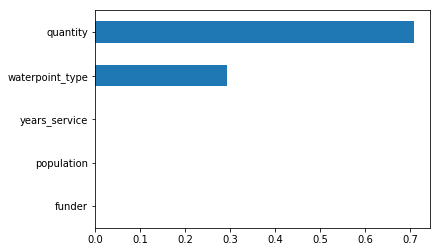

In [179]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
import category_encoders as ce

pipe = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(),  
    DecisionTreeClassifier(max_depth=2, class_weight=None)
)

pipe.fit(X_train, y_train)
print('Validation accuracy:' ,pipe.score(X_val, y_val), 'Train accuracy:', pipe.score(X_train, y_train))
pd.Series(pipe.named_steps.decisiontreeclassifier.feature_importances_, X_train.columns).sort_values(ascending=True).tail().plot(kind='barh');

In [14]:
len(X_train.columns)

30

In [148]:
pipe = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(),  
    XGBClassifier(n_jobs=-1, class_weight=None, n_estimators=150, max_depth=7, verbose=10, random_state=42)
)

pipe.fit(X_train, y_train)
print('Validation accuracy:', pipe.score(X_val, y_val), 'Train accuracy:', pipe.score(X_train, y_train))

Validation accuracy: 0.790993265993266 Train accuracy: 0.8456228956228956


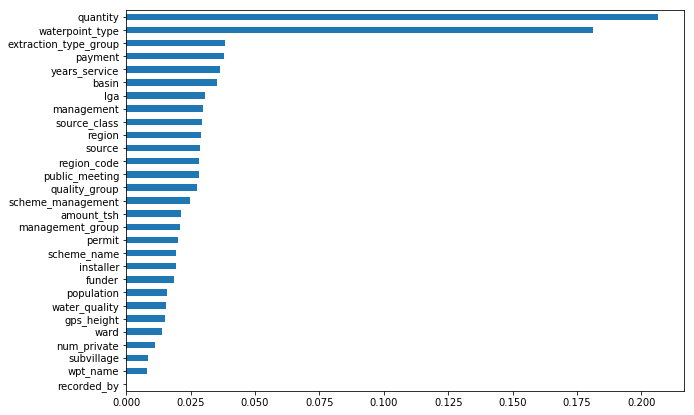

In [117]:
plt.figure(figsize=(10,7))
pd.Series(pipe.named_steps.xgbclassifier.feature_importances_, X_train.columns).sort_values(ascending=True).tail(100).plot(kind='barh');

In [180]:
pipe = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(),  
    RandomForestClassifier(n_jobs=-1, class_weight=None, n_estimators=100, max_depth=20, random_state=42)
)

pipe.fit(X_train, y_train)
print('Validation accuracy:', pipe.score(X_val, y_val), 'Train accuracy:', pipe.score(X_train, y_train))

Validation accuracy: 0.8015993265993266 Train accuracy: 0.9610900673400673


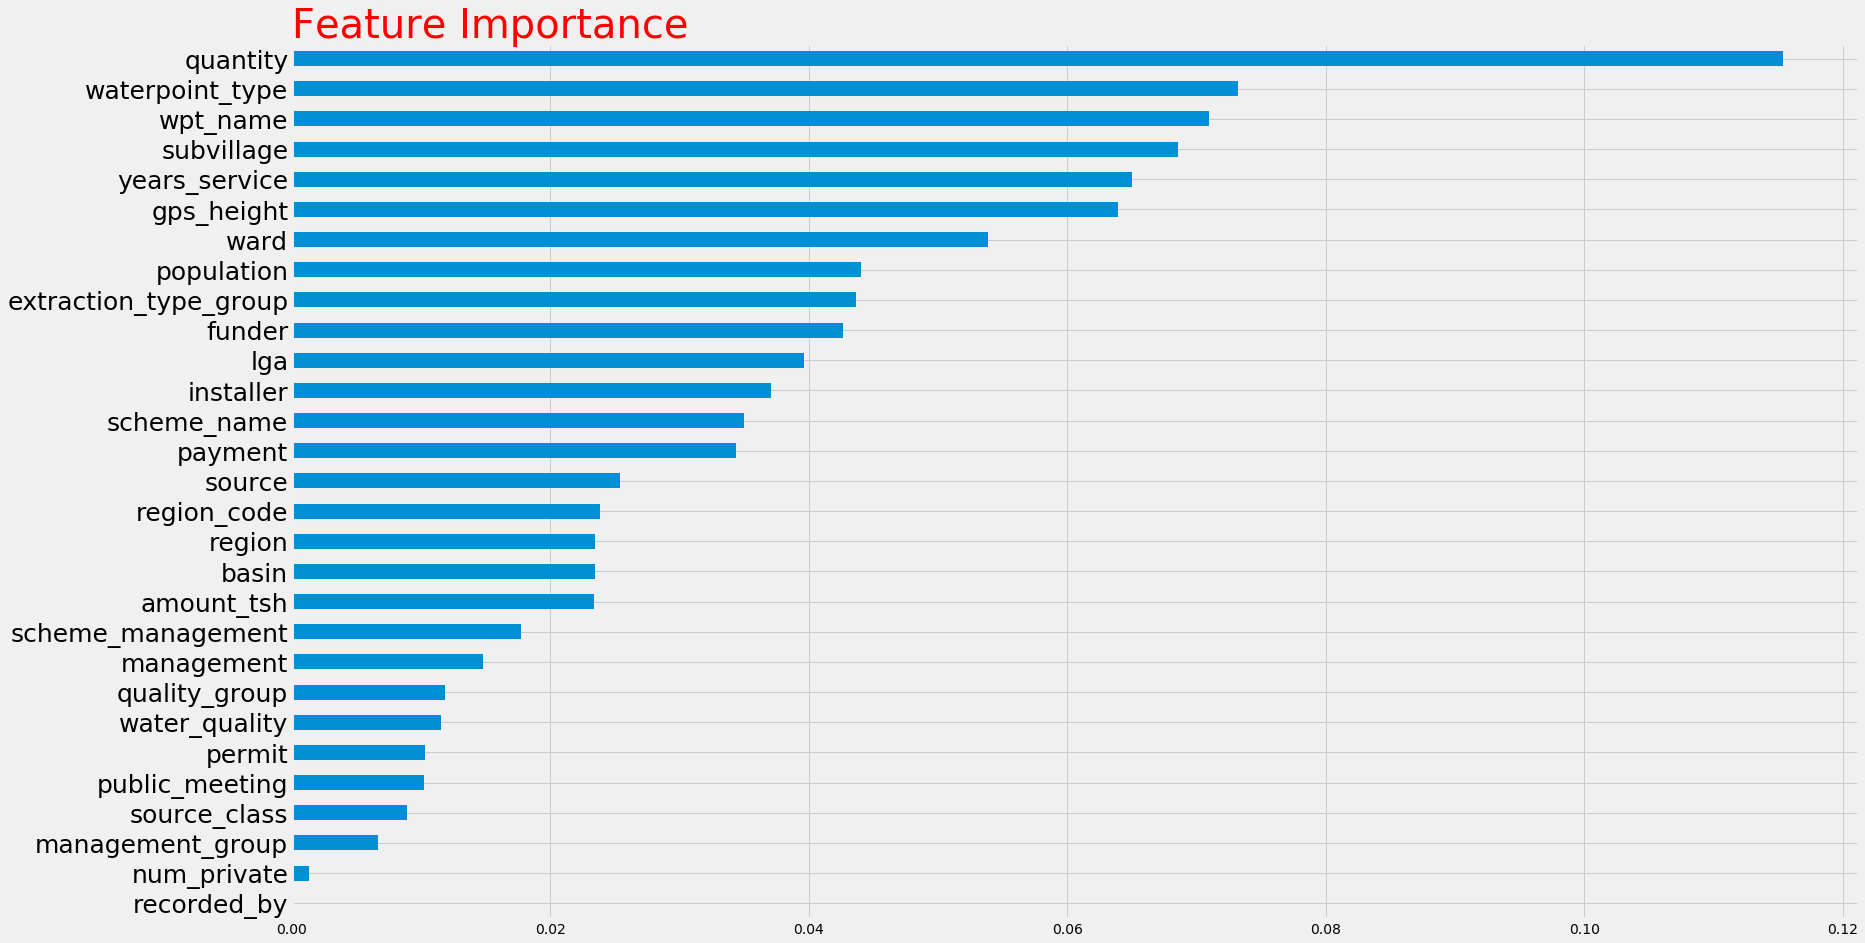

In [214]:
import matplotlib
matplotlib.style.use('fivethirtyeight')
plt.rcParams['figure.figsize']=(25,15)
plt.title('Feature Importance', loc='left', fontsize=40, color='red')
ax = pd.Series(pipe.named_steps.randomforestclassifier.feature_importances_, X_train.columns).sort_values(ascending=True).tail(100).plot(kind='barh')
for tick in ax.yaxis.get_major_ticks(): #y-axis labels fontsize
  tick.label.set_fontsize(25)

In [0]:
pipe.steps

In [0]:
y_pred = pipe.predict(test_features)

# Makes a dataframe with two columns, id and status_group, 
# and writes to a csv file, without the index

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('rf_no_feature_selection.csv', index=False)
files.download('rf_no_feature_selection.csv')

In [0]:
def cramers_v(x, y):
    import scipy.stats as ss
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [142]:
cramers_v(X_train.quantity, X_train.waterpoint_type)

0.09148719760630807

In [0]:
!pip install eli5
!pip install pdpbox
!pip install shap

In [181]:
transformer = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer()
)
X_train_trans = transformer.fit_transform(X_train)
X_val_trans = transformer.transform(X_val)

xgb = XGBClassifier(n_jobs=-1, class_weight=None, n_estimators=150, max_depth=7, verbose=10, random_state=42)
xgb.fit(X_train_trans, y_train)
print('Validation accuracy:', xgb.score(X_val_trans, y_val), 'Train accuracy:', xgb.score(X_train_trans, y_train))

Validation accuracy: 0.790993265993266 Train accuracy: 0.8456228956228956


In [0]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(xgb, scoring='accuracy', cv='prefit', 
                                 n_iter=2, random_state=42)

permuter.fit(X_train_trans, y_train)

In [151]:
feature_names = X_train.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.1206 ± 0.0008,quantity
0.0513 ± 0.0005,waterpoint_type
0.0359 ± 0.0000,years_service
0.0313 ± 0.0004,lga
0.0311 ± 0.0006,extraction_type_group
0.0275 ± 0.0010,payment
0.0231 ± 0.0009,population
0.0214 ± 0.0003,ward
0.0190 ± 0.0015,gps_height
0.0181 ± 0.0005,funder


In [182]:
rf = RandomForestClassifier(n_jobs=-1, class_weight=None, n_estimators=100, max_depth=20, random_state=42)
rf.fit(X_train_trans, y_train)
print('Validation accuracy:', rf.score(X_val_trans, y_val), 'Train accuracy:', rf.score(X_train_trans, y_train))

Validation accuracy: 0.8015993265993266 Train accuracy: 0.9610900673400673


In [154]:
permuter = PermutationImportance(rf, scoring='accuracy', cv='prefit', 
                                 n_iter=2, random_state=42)

permuter.fit(X_train_trans, y_train)
feature_names = X_train.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.1578 ± 0.0009,quantity
0.0904 ± 0.0004,waterpoint_type
0.0759 ± 0.0005,years_service
0.0697 ± 0.0009,payment
0.0520 ± 0.0011,extraction_type_group
0.0401 ± 0.0004,subvillage
0.0392 ± 0.0006,wpt_name
0.0382 ± 0.0013,gps_height
0.0343 ± 0.0010,ward
0.0340 ± 0.0005,funder


In [215]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'amount_tsh'

isolated = pdp_isolate(
    model=rf, 
    dataset=X_train, 
    model_features=X_train.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

ValueError: ignored

In [0]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['latitude', 'longitude']

interaction = pdp_interact(
    model=rf, 
    dataset=X_val, 
    model_features=X_val.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);
plt.figure(figsize=(20,20));